# <span style="color: yellow;">Problem Statement</span>


### To analyze and model the relationship between various health-related features and medical costs using linear regression. The primary objective is to predict the target variable, charges, based on the independent variables such as age, BMI, sex, smoker status, and region. The project involves fitting a linear regression model using Ordinary Least Squares (OLS) to estimate the coefficients, predict charges, and evaluate the model for issues like heteroskedasticity and endogeneity. Statistical tests such as the Goldfeld-Quandt, and Durbin-Watson tests are employed to assess model assumptions, while corrections are applied to improve the model's validity. This approach provides valuable insights into how health metrics influence medical charges and ensures the robustness of the regression model.


# <span style="color: yellow;">Importing Libreries </span>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson


# <span style="color: yellow;">Importing Data</span>


In [3]:
data = pd.read_csv("insurance.csv")

In [4]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500



# <span style="color: yellow;">Checking For empty data</span>


In [6]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<Axes: >

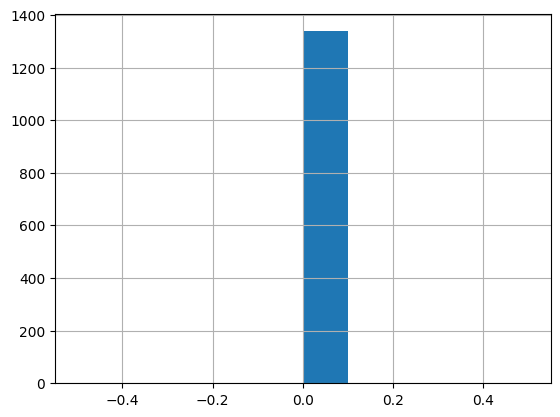

In [8]:
data.isnull().sum(axis=1).hist()

#### Conclusion: There are no empty fields


# <span style="color: yellow;">Exploratory Data Analysis</span>


##  <span style="color: pink;">Datatypes of the features</span>


In [10]:
# Check number of rows and columns
print("Dataset size:", data.shape)

# Display column names and data types
print("\nColumn names and data types:\n")
print(data.dtypes)


Dataset size: (1338, 7)

Column names and data types:

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


## <span style="color: pink;">Description of numerical features</span>


In [11]:
# Generate descriptive statistics for numerical features
print("\nSummary statistics for numerical columns:\n")
print(data.describe())



Summary statistics for numerical columns:

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


## <span style="color: pink;">Finding outliers in target variable (charges)</span>



Number of outliers in 'charges': 139


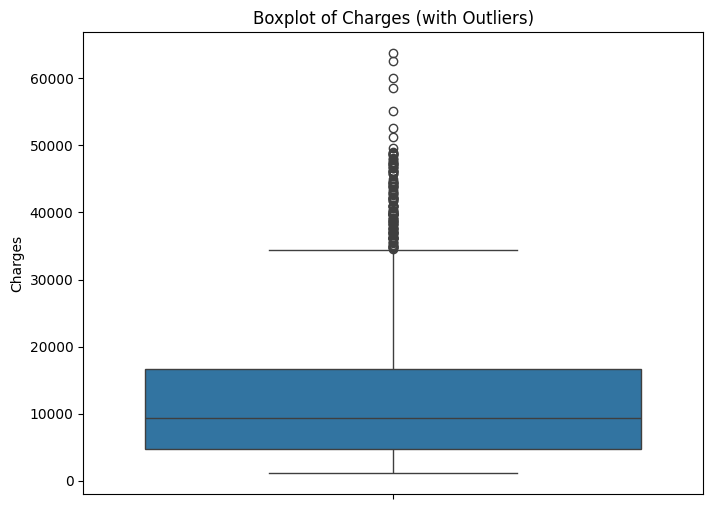

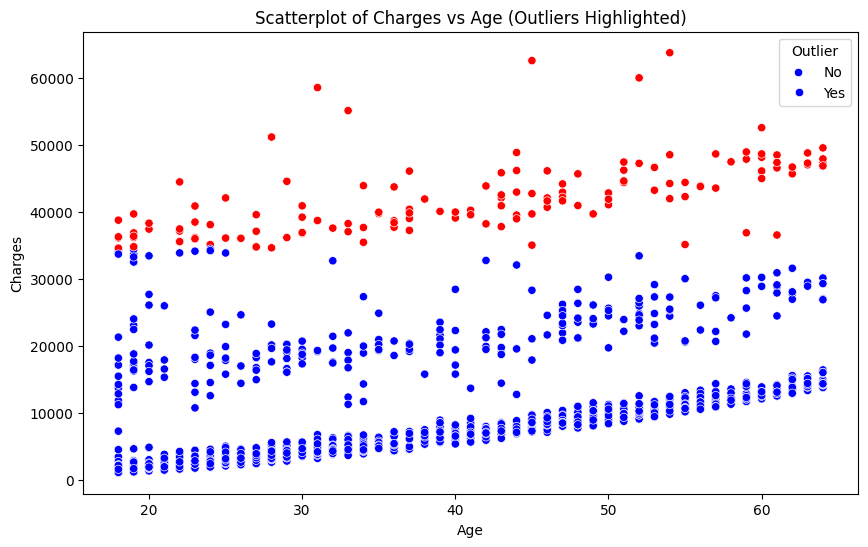

In [32]:
# Detect outliers using IQR
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers = find_outliers_iqr(data, 'charges')  # Replace 'charges' with the column of interest
print(f"\nNumber of outliers in 'charges': {len(outliers)}")



# Boxplot to visualize outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, y='charges')
plt.title("Boxplot of Charges (with Outliers)")
plt.ylabel("Charges")
plt.show()

# Scatterplot to visualize outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='age', y='charges', hue=data['charges'].isin(outliers['charges']), palette={True: 'red', False: 'blue'})
plt.title("Scatterplot of Charges vs Age (Outliers Highlighted)")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.legend(title="Outlier", labels=["No", "Yes"])
plt.show()


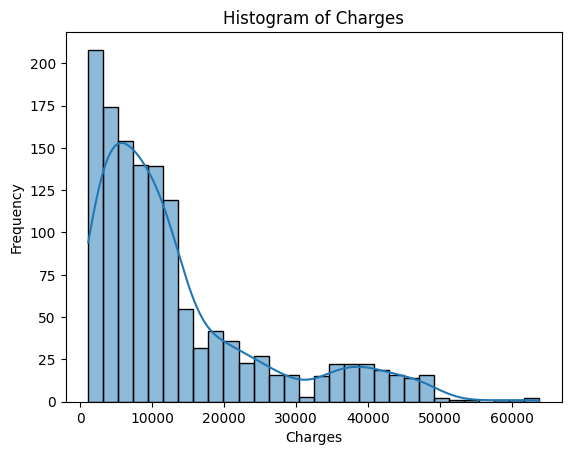

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame containing the 'charges' column
sns.histplot(data['charges'], kde=True, bins=30)  # kde=True adds a Kernel Density Estimate curve
plt.title('Histogram of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()


## <span style="color: pink;">Distribution of Numerical Features </span>


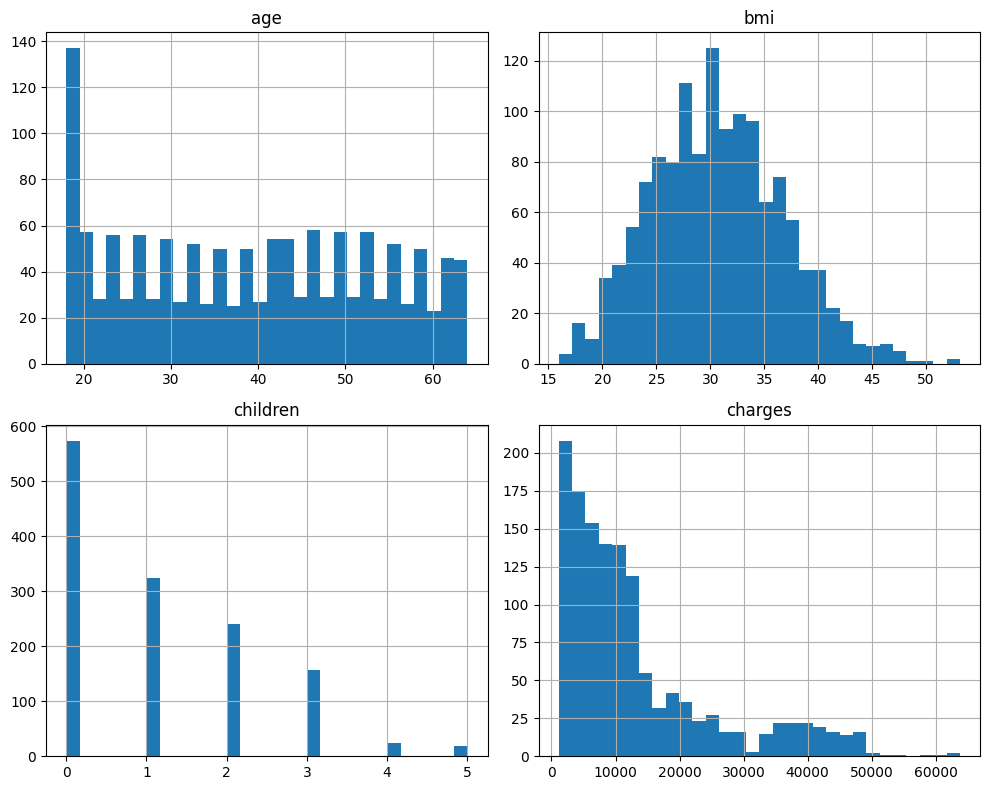

In [28]:
import matplotlib.pyplot as plt

# Plot histograms for numeric variables
data.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()


## <span style="color: pink;">Distribution of Catagorical features</span>


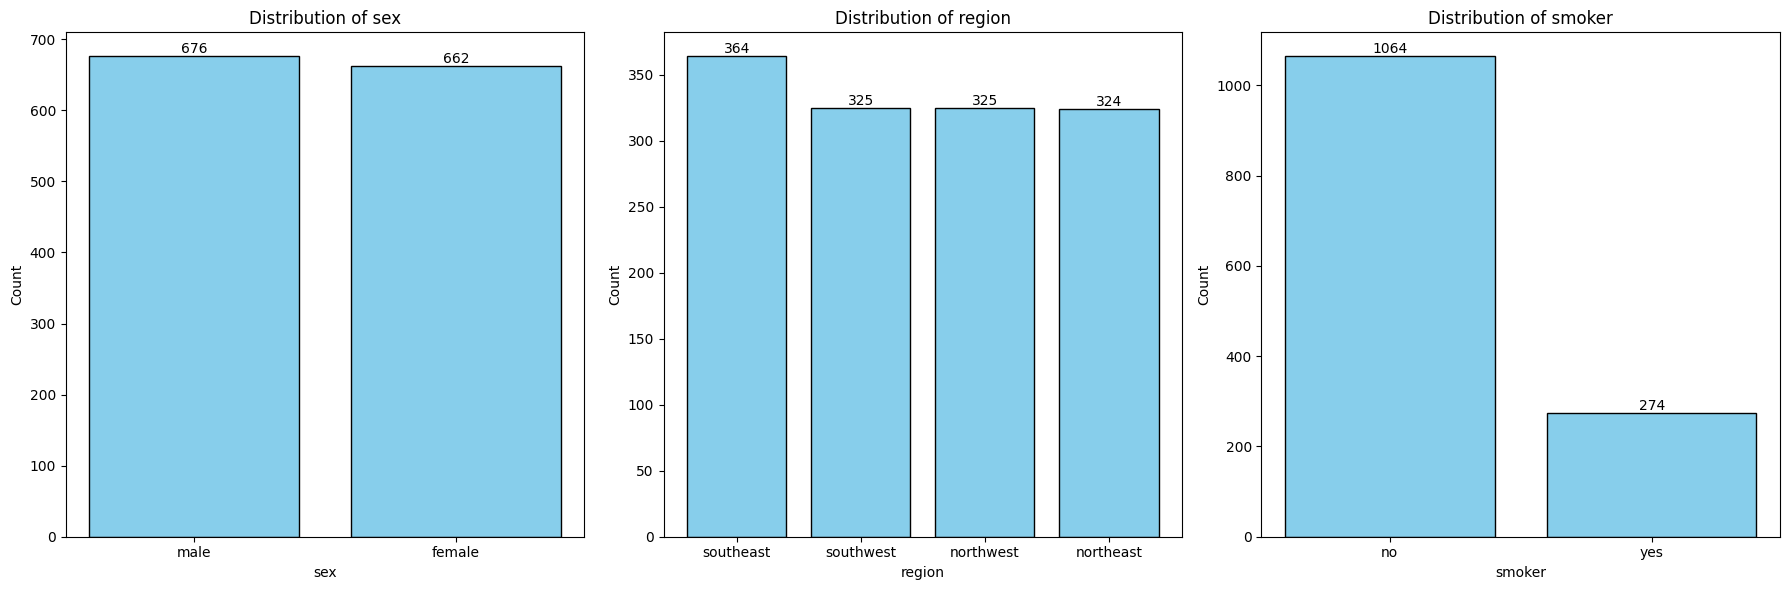

In [29]:
import matplotlib.pyplot as plt

# Define categorical columns
categorical_cols = ['sex', 'region', 'smoker']

# Create subplots: one row, multiple columns
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(18, 6))

# Loop through each categorical column and plot
for i, col in enumerate(categorical_cols):
    counts = data[col].value_counts()
    bars = axes[i].bar(counts.index, counts.values, color='skyblue', edgecolor='black')

    # Annotate bars with counts
    for bar in bars:
        axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                     str(int(bar.get_height())), ha='center', va='bottom')

    # Set title and labels
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


## <span style="color: pink;"> Correlation Analysis</span>


In [17]:
# Select only numeric columns
numeric_data = data.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Display correlations
print("\nCorrelation matrix:\n", correlation_matrix)



Correlation matrix:
                age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


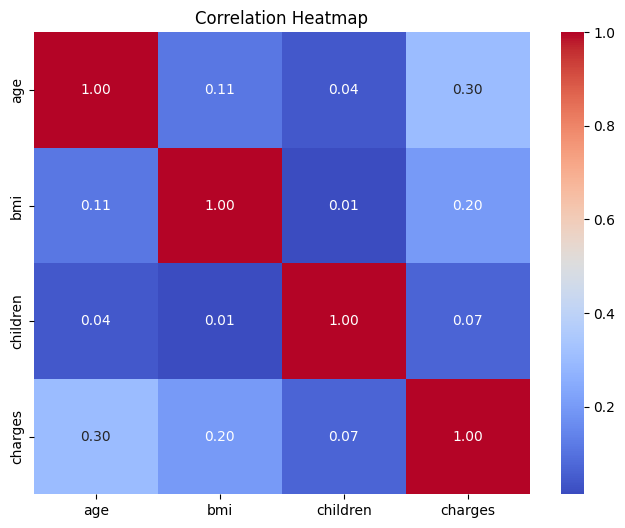

In [18]:
import seaborn as sns

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


##  <span style="color: pink;">Feature Comparisons</span>


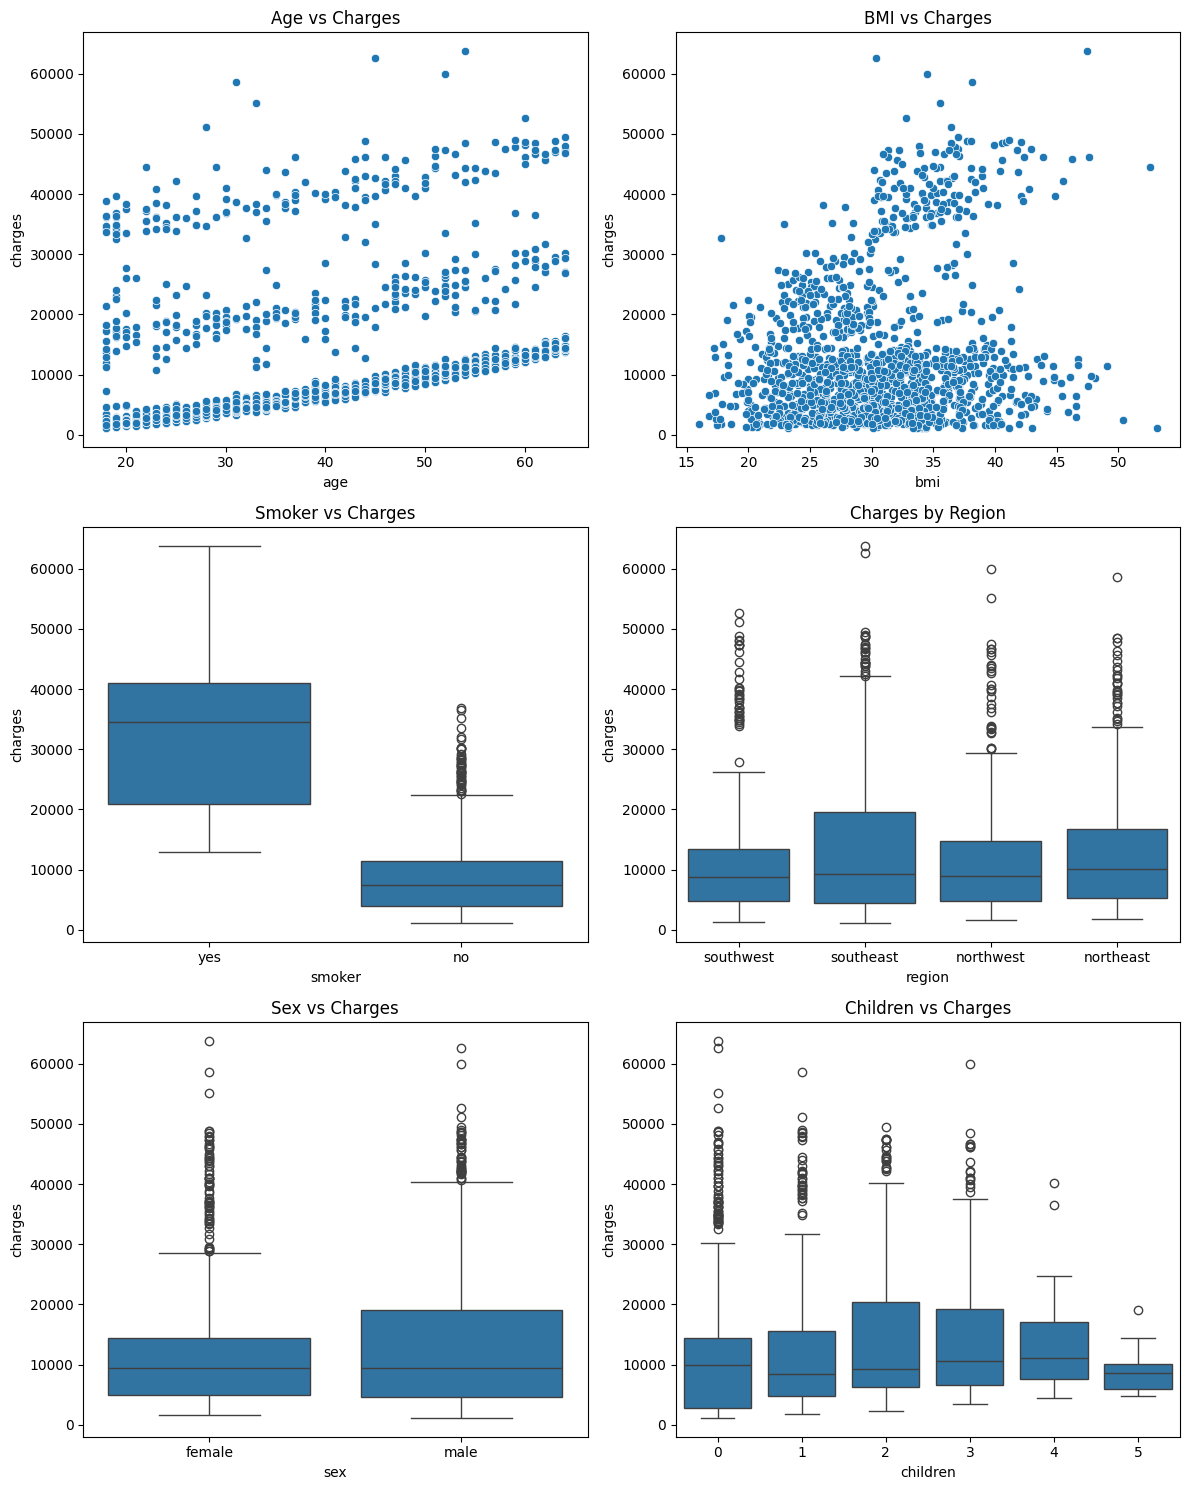

In [ ]:
# Create a figure and axes for a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3x2 grid of subplots

# Scatterplot: Age vs Charges
sns.scatterplot(data=data, x='age', y='charges', ax=axes[0, 0])
axes[0, 0].set_title("Age vs Charges")

# Scatterplot: BMI vs Charges
sns.scatterplot(data=data, x='bmi', y='charges', ax=axes[0, 1])
axes[0, 1].set_title("BMI vs Charges")

# Boxplot: Smoker vs Charges
sns.boxplot(data=data, x='smoker', y='charges', ax=axes[1, 0])
axes[1, 0].set_title("Smoker vs Charges")

# Boxplot: Charges by Region
sns.boxplot(data=data, x='region', y='charges', ax=axes[1, 1])
axes[1, 1].set_title("Charges by Region")

# Boxplot: Sex vs Charges
sns.boxplot(data=data, x='sex', y='charges', ax=axes[2, 0])
axes[2, 0].set_title("Sex vs Charges")

# Boxplot: Children vs Charges
sns.boxplot(data=data, x='children', y='charges', ax=axes[2, 1])
axes[2, 1].set_title("Children vs Charges")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [21]:
# Crosstab: Sex vs Smoker
print("\nCrosstab of Sex and Smoker:")
print(pd.crosstab(data['sex'], data['smoker']))



Crosstab of Sex and Smoker:
smoker   no  yes
sex             
female  547  115
male    517  159


In [22]:
# Grouped average charges by smoker status
charges_by_smoker = data.groupby('smoker')['charges'].mean()
print("\nAverage charges by smoker status:\n", charges_by_smoker)



Average charges by smoker status:
 smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64


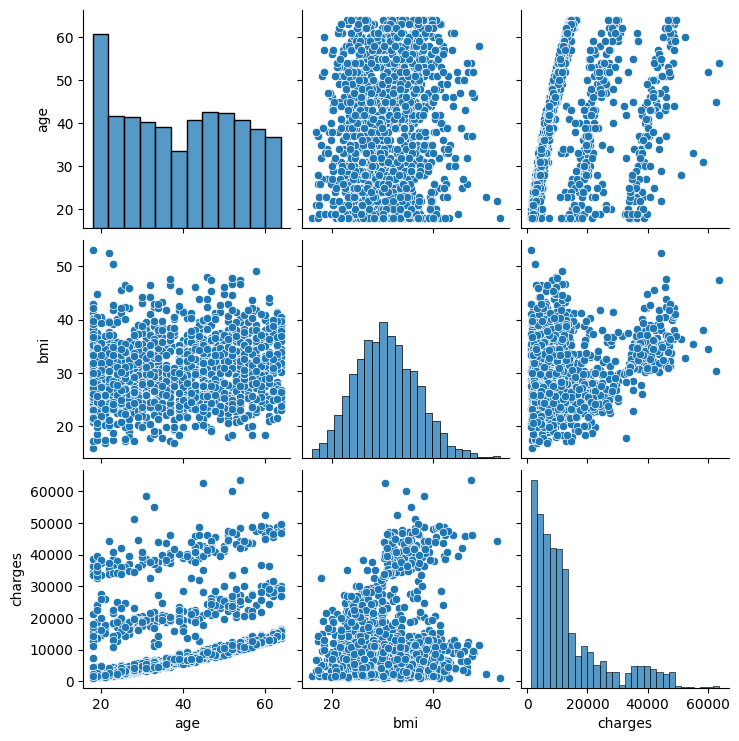

In [38]:
# Pairplot to explore relationships
sns.pairplot(data, vars=['age', 'bmi','charges'])
plt.show()


In [42]:
import pandas as pd

# Load the dataset
data = pd.read_csv("insurance.csv")

# Convert 'sex' to 0 (male) and 1 (female)
data['sex'] = data['sex'].map({'male': 0, 'female': 1})

# Convert 'smoker' to 1 (smoker) and 0 (non-smoker)
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

# Convert 'region' to integer values
regions = {'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}
data['region'] = data['region'].map(regions)

# Display the updated DataFrame
data


,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,0,16884.92400
1,18,0,33.770,1,0,1,1725.55230
2,28,0,33.000,3,0,1,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,2,10600.54830
1334,18,1,31.920,0,0,3,2205.98080
1335,18,1,36.850,0,0,1,1629.83350
1336,21,1,25.800,0,0,0,2007.94500


# <span style="color: yellow;">Regression Analysis</span>


In [43]:
data.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

## <span style="color: pink;">OLS estimation</span>


In [89]:
# Define the target variable (Y) and regressors (X)
X = data.drop(columns=['charges'])  # Regressors: all columns except 'charges'
y = data['charges']  # Target variable: 'charges'


In [97]:
X.shape

(1338, 6)

In [103]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Normalize the features (X) and target (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Normalize X and y
X_normalized = scaler_X.fit_transform(X)  # Normalize features
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Normalize target

# Add a constant term to X for the model intercept
X_const = sm.add_constant(X_normalized)

# Fit the OLS model
ols_model = sm.OLS(y_normalized, X_const).fit()

# Print the summary of the OLS regression
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     668.1
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:50:18   Log-Likelihood:                -969.13
No. Observations:                1338   AIC:                             1952.
Df Residuals:                    1331   BIC:                             1989.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.058e-17      0.014   -3.7e-15      1.0

In [109]:
# Ensure y_normalized and y_pred are 1D arrays
y_pred = ols_model.predict(X_const).flatten()  # Flatten to 1D array
u_hat = y_normalized.flatten() - y_pred  # Calculate residuals

# Print the first few values of y_pred and u_hat
print("Predicted values (y_pred):")
print(y_pred[:5])  # First 5 predicted values
print("\nResiduals (u_hat):")
print(u_hat[:5])  # First 5 residuals


Predicted values (y_pred):
[ 0.97813674 -0.79160952 -0.52102634 -0.78717324 -0.63878328]

Residuals (u_hat):
[-0.67955294 -0.16207966 -0.20764833  1.50701622 -0.1380189 ]


##  <span style="color: pink;">Test for Heteroskedasticity</span>


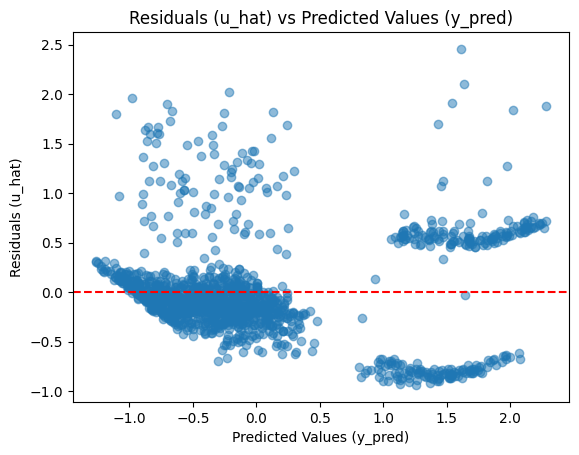

In [110]:
import matplotlib.pyplot as plt

# Plot u_hat vs y_pred
plt.scatter(y_pred, u_hat, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # Line at y = 0
plt.title('Residuals (u_hat) vs Predicted Values (y_pred)')
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Residuals (u_hat)')
plt.show()


In [116]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Perform the Goldfeld-Quandt test for heteroskedasticity
gq_test_result = het_goldfeldquandt(u_hat, X_const)

# Extract the test statistic and p-value
gq_test_stat = gq_test_result[0]
gq_test_p_value = gq_test_result[1]

# Display the result of the test
print(f"Goldfeld-Quandt Test Statistic: {gq_test_stat}")
print(f"Goldfeld-Quandt p-value: {gq_test_p_value}")

# Conclusion
if gq_test_p_value < 0.05:
    print("There is heteroskedasticity (reject the null hypothesis of homoskedasticity).")
else:
    print("There is no heteroskedasticity (fail to reject the null hypothesis of homoskedasticity).")


Goldfeld-Quandt Test Statistic: 0.9566557936681559
Goldfeld-Quandt p-value: 0.7155988668351111
There is no heteroskedasticity (fail to reject the null hypothesis of homoskedasticity).


##  <span style="color: pink;">Test for Endogeneity</span>


In [117]:
import numpy as np

# Calculate the correlation between y_pred (predicted values) and u_hat (residuals)
correlation = np.corrcoef(y_pred.flatten(), u_hat.flatten())[0, 1]

# Display the correlation value
print(f"Correlation between y_pred and u_hat: {correlation}")

# Conclusion
if abs(correlation) < 0.1:
    print("There is no endogeneity (correlation is close to 0).")
else:
    print("There is endogeneity (correlation is significantly different from 0).")


Correlation between y_pred and u_hat: -2.834250929347324e-15
There is no endogeneity (correlation is close to 0).


##  <span style="color: pink;">MultiColinearity</span>


In [123]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the feature set (for intercept term)
X = data.drop('charges', axis=1)  # Excluding target variable 'charges'
X = add_constant(X)  # Adds a column of ones for the intercept term

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print("VIF Values:")
print(vif_data)

# Conclusion based on VIF values
vif_conclusion = "\nNo multicollinearity concerns:\n"
for index, row in vif_data.iterrows():
    if row['VIF'] > 10:
        vif_conclusion += f"Feature '{row['feature']}' has high multicollinearity (VIF > 10).\n"
    elif row['VIF'] > 5:
        vif_conclusion += f"Feature '{row['feature']}' has moderate multicollinearity (VIF > 5).\n"
    else:
        vif_conclusion += f"Feature '{row['feature']}' has no significant multicollinearity (VIF < 5).\n"

# Output the conclusion
print(vif_conclusion)


VIF Values:
    feature        VIF
0     const  38.335629
1       age   1.015394
2       sex   1.008889
3       bmi   1.040608
4  children   1.002482
5    smoker   1.006466
6    region   1.025966

No multicollinearity concerns:
Feature 'const' has high multicollinearity (VIF > 10).
Feature 'age' has no significant multicollinearity (VIF < 5).
Feature 'sex' has no significant multicollinearity (VIF < 5).
Feature 'bmi' has no significant multicollinearity (VIF < 5).
Feature 'children' has no significant multicollinearity (VIF < 5).
Feature 'smoker' has no significant multicollinearity (VIF < 5).
Feature 'region' has no significant multicollinearity (VIF < 5).



##  <span style="color: pink;">Test for Normality of Residuals</span>


##### Q-Q plot

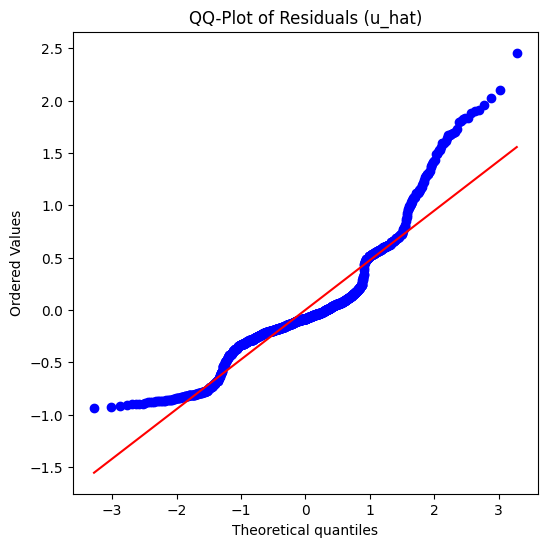

In [120]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera
import scipy.stats as stats

# Create the QQ-Plot
plt.figure(figsize=(6, 6))
stats.probplot(u_hat.flatten(), dist="norm", plot=plt)
plt.title('QQ-Plot of Residuals (u_hat)')
plt.show()


##### Jarque-Bera test

In [121]:

# Perform the Jarque-Bera test
jb_test_result = jarque_bera(u_hat.flatten())

# Display the result of the Jarque-Bera test
print(f"Jarque-Bera test statistic: {jb_test_result[0]}")
print(f"Jarque-Bera p-value: {jb_test_result[1]}")

# Conclusion based on p-value
if jb_test_result[1] < 0.05:
    print("Reject the null hypothesis: Residuals are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Residuals are normally distributed.")

Jarque-Bera test statistic: 713.974804487291
Jarque-Bera p-value: 9.169403759917066e-156
Reject the null hypothesis: Residuals are not normally distributed.
